# 1.7 노드 병렬 처리를 통한 효율 개선 (feat. 프롬프트 엔지니어링)

- 답변을 생성할 때 다양한 정보가 필요하다면 병렬 처리를 통해 시간을 절약할 수 있습니다

In [1]:
import nest_asyncio
nest_asyncio.apply()

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str # 사용자 질문
    answer: str # 최종 답변
    month_rent_condition_information: str # 청년월세지원 조건 정보
    target_name: str # 청년월세지원 대상자 이름
    target_information: str # 청년월세지원 대상자 정보
    
graph_builder = StateGraph(AgentState)

In [3]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'chroma_collection',
    persist_directory = './chroma_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 1})

In [4]:
from langchain_openai import ChatOpenAI
from langchain_classic import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

rag_prompt = hub.pull('rlm/rag-prompt')
llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
month_rent_retrieval_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

month_rent_condition_prompt = ChatPromptTemplate.from_messages([
    ('system', '사용자의 입력에서 청년월세지원 조건을 깔끔하게 정리해주세요.'),
    ('human', '{month_rent_condition_information}')
])

month_rent_condition_chain = (
    {'month_rent_condition_information': RunnablePassthrough()}
    | month_rent_condition_prompt
    | llm
    | StrOutputParser()
)

month_rent_chain = {'month_rent_equation_information' : month_rent_retrieval_chain} | month_rent_condition_chain

def get_month_rent_condition(state: AgentState) -> AgentState:

    month_rent_condition_question = '청년월세지원 신청조건에 대한 내용을 정리해주세요.'

    month_rent_condition = month_rent_chain.invoke(month_rent_condition_question)

    return {'month_rent_condition_information': month_rent_condition}

In [6]:
from langchain_community.tools import TavilySearchResults
from datetime import date

tavily_search_tool = TavilySearchResults(
    max_results=1,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=False,
    include_images=False,
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', f'아래 정보를 기반으로 대상자의 나이, 소득, 주택 소유 여부를 판단해주세요.\n\nContext:\n{{context}}'),
    ('human', '{query}')
])

# 대상자를 추출하는 함수
def get_target_extract(query: str) -> str:
    prompt = ChatPromptTemplate.from_messages([
        ('system', '사용자의 질문에서 언급되고 있는 사람의 이름을 추출해주세요. 추가적인 문장없이 이름만 추출해주세요.'),
        ('human', '{query}')
    ])
    chain = prompt | llm | StrOutputParser()
    target_name = chain.invoke({'query': query})

    return target_name

def get_target_information(state: AgentState) -> AgentState:
    target_name = get_target_extract(state['query'])

    query = f'{target_name}의 기본정보(나이, 소득, 주택 소유 여부)를 검색해주세요.'
    
    # tavily_search_tool을 사용하여 쿼리를 실행하고 컨텍스트를 얻습니다.
    context = tavily_search_tool.invoke(query)
    
    target_information_chain = (
        tax_market_ratio_prompt
        | llm
        | StrOutputParser()
    )
    
    target_information = target_information_chain.invoke({'context': context, 'query': query})
    
    return {'target_information': target_information, "target_name": target_name}

/var/folders/qt/w7p0s8cx51q4dh533wlpsbrm0000gn/T/ipykernel_6363/2397691484.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [7]:
final_answer_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 청년월세지원 담당자입니다. 아래 문서를 참고해서 사용자의 질문에 대한 청년월세지원 신청 가능 여부를 판단해주세요.

청년월세지원 신청 조건:{context}'''),
    ('human', '''다음 대상자의 청년월세신청 가능여부를 판별해주세요.

대상자이름: {target_name}
대상자 정보: {target_information}''')
])

def final_answer_generation(state: AgentState):
    # state에서 필요한 정보를 추출합니다.
    query = state['query']
    month_rent_condition_information = state['month_rent_condition_information']
    target_name = state['target_name']
    target_information = state['target_information']
    
    final_answer_chain = (
        final_answer_prompt
        | llm
        | StrOutputParser()
    )
    
    # tax_rate_chain을 사용하여 세율을 계산합니다.
    final_answer = final_answer_chain.invoke({
        'context': month_rent_condition_information, 
        'target_name': target_name, 
        'target_information': target_information,
    })

    # state에서 'answer' 키에 대한 값을 반환합니다.
    return {'answer': final_answer}

- `node`를 추가하고 `edge`로 연결합니다
- 하나의 `node`에서 `edge`를 활영해서 다양한 `node`들을 연결하면 병렬로 작업이 가능합니다

In [8]:
graph_builder.add_node('get_month_rent_condition', get_month_rent_condition)
graph_builder.add_node('get_target_information', get_target_information)
graph_builder.add_node('final_answer_generation', final_answer_generation)

In [9]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'get_month_rent_condition')
graph_builder.add_edge(START, 'get_target_information')

graph_builder.add_edge('get_month_rent_condition', 'final_answer_generation')
graph_builder.add_edge('get_target_information', 'final_answer_generation')

graph_builder.add_edge('final_answer_generation', END)

In [10]:
graph = graph_builder.compile()

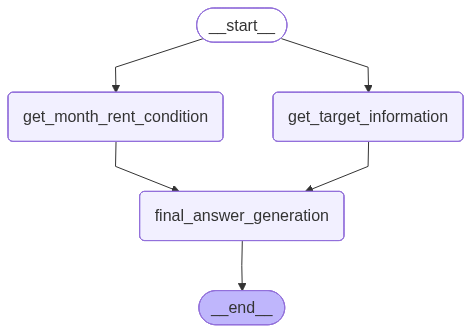

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
query = '유재석은 청년월세지원 조건에 부합한가요??'

initial_state = {'query': query}
graph.invoke(initial_state)

{'query': '유재석은 청년월세지원 조건에 부합한가요??',
 'answer': '유재석은 청년월세지원 신청 조건을 충족하지 않습니다.\n\n1. **연령**: 53세로, 39세 이하의 조건을 충족하지 않음.\n2. **주거 형태**: 주택을 소유하고 있으므로 무주택 1인 가구가 아님.\n\n따라서 유재석은 청년월세지원 신청이 불가합니다.',
 'month_rent_condition_information': '청년월세지원 신청 조건:\n\n1. **연령**: 19세에서 39세 이하\n2. **주거 형태**: 무주택 1인 가구\n3. **주민등록**: 서울시에 주민등록이 되어 있어야 함\n4. **임차계약**: 임차계약을 체결한 경우 지원 불가\n5. **신청자 자격**: \n   - 한국 국적의 청년\n   - 외국인 신청자 불가\n   - 재외국민의 건강보험 가입자 또는 피부양자는 신청 가능\n\n이 조건들을 충족해야 청년월세지원을 신청할 수 있습니다.',
 'target_name': '유재석',
 'target_information': '유재석의 기본 정보는 다음과 같습니다:\n\n- **나이**: 53세 (1972년 8월 14일 생)\n- **소득**: 구체적인 소득 정보는 제공되지 않았으나, 유재석은 대한민국에서 매우 인기 있는 방송인이기 때문에 높은 소득을 올리고 있을 것으로 예상됩니다.\n- **주택 소유 여부**: 유재석은 논현동의 고급빌라를 매입하여 거주하고 있습니다. 따라서 주택을 소유하고 있습니다.'}